<a href="https://colab.research.google.com/github/MikFerrari/SMLHF_GoogleColabs/blob/main/2021_10_05_TP1_dynamic_programming_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Ferlinghetti Enrico [21118263]
- Ferrari Michele [21118273]
- Strazzullo Alessandra [21118266]

# Outlook #

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [ ]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install git+https://github.com/osigaud/SimpleMazeMDP

  Cloning https://github.com/osigaud/SimpleMazeMDP to /tmp/pip-req-build-e3tn3p8s
  Running command git clone -q https://github.com/osigaud/SimpleMazeMDP /tmp/pip-req-build-e3tn3p8s
  Created wheel for mazemdp: filename=mazemdp-0.5.dev0+b4be43c9fddbc46d42efe357ffd02b11bbc258d2-py3-none-any.whl size=14211 sha256=7c7df5e23220c0df92790b0d922ea807bd14fea48f76cd49166ab56d248571dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sg51kv_/wheels/a7/b2/31/9dc75dc84c83345df75f8d1881a0a862205b93d7e457f2aa45
Successfully built mazemdp


In [ ]:
!pip install tabulate # library for visualizing tables

In [ ]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp

from tabulate import tabulate


# For visualization
os.environ["VIDEO_FPS"] = "5"


# Customize Chrono class in file mazemdp.chrono.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Author: Olivier Sigaud
Module: Chrono
Description: Class to display time spent in human format rather than seconds
"""

import time

class Chrono:
    def __init__(self):
        self.name = "Chrono"
        self.start = time.time()

    def stop(self) -> str:
        stop = time.time()
        dif = stop - self.start
        difstring = ""
        if dif > 3600:
            heures = int(dif / 3600)
            difstring = str(heures) + "h "
            dif = dif - (heures * 3600)
        if dif > 60:
            minutes = int(dif / 60)
            difstring = difstring + str(minutes) + "mn "
            dif = dif - (minutes * 60)
        difstring = difstring + str(int(dif)) + "s "
        dif = int((dif - int(dif)) * 1000)
        difstring = difstring + str(dif) + "ms"
        # print(f"Time : {difstring}")

        return difstring


Matplotlib backend: module://ipykernel.pylab.backend_inline


# Agents and MDPs #


A reinforcement learning agent interacts with an environment represented as a Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$ where $S$ is the state space, $A$ is the action space, $P(state_t, action_t, state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward function and $\gamma \in [0, 1]$ is the discount factor.



In what follows we import code to create an MDP corresponding to a random maze (see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [ ]:
from mazemdp import create_random_maze

mdp = create_random_maze(10, 10, 0) # 0.2 = percentage of black cells in the maze

# Dynamic programming #


The goal of an RL agent is to find the optimal behaviour, defined by a policy $\pi$ that assigns an action (or distribution over actions) to each state so as to maximize the agent's total expected reward. In order to estimate how good a state is, either a state value function $V(x)$ or a state-action value function $Q(x,u)$ is used.

Dynamic programming algorithms are used for planning, they require a full knowledge of the MDP from the agent (in contrast to "true" RL where the agent does not know the transition and reward functions).
They find the optimal policy by computing a value function $V$ or an action-value function $Q$ over the state space or state-action space of the given MDP. **Value iteration** and **policy iteration** are two standard dynamic programming algorithms. You should study both of them using both $V$ and $Q$, as these algorithms contain the basic building blocks for most RL algorithms.


## Value Iteration ##

### Value Iteration with the V function ###



When using the $V$ function, **value iteration** aims at finding the optimal values $V^*$ based on the Bellman Optimality Equation:
$$V^*(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$

where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action $a$ in state $s$, 
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance of long term rewards over short term ones (the closer to 0, the more the agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the values of all states are 0), and then we iterate for all states $s$

$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y) \big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first define the `get_policy_from_V()` function

In [ ]:
def get_policy_from_v(mdp: Mdp, v: np.ndarray) -> np.ndarray: # this syntax allows to specify the type of the output: use recommended!
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        v_temp = []
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            else:  # if the state is final, then we only take the reward into account
                   # --> Convention (one of the possible) necessary to deal with the terminal state,
                   #     for which the Bellman Equation does not hold
                v_temp.append(mdp.r[x, u])
        policy[x] = np.argmax(v_temp)
    return policy


The `value_iteration_v(mdp)` function below provides the code of **value iteration** using the $V$ function. It is given as an example from which you can derive other instances of dynamic programming algorithms. Look at it more closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these updates until the values don't change significantly anymore, the main update equation. Found them? OK, you can continue...


In [ ]:
# ------------------------- Value Iteration with the V function ----------------------------#
# Given a MDP, this algorithm computes the optimal state value function V
# It then derives the optimal policy based on this function
# This function is given


def value_iteration_v(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float], int, float, str]:
    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    if render:
        mdp.new_render("Value iteration V")

    while not stop:
        # Start timer for the current iteration
        start_timer_iter = time.time()

        v_old = v.copy()
        if render:
            mdp.render(v, title="Value iteration V")

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                if x not in mdp.terminal_states:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
                else:  # if the state is final, then we only take the reward into account
                    v_temp.append(mdp.r[x, u])

                    # Select the highest state value among those computed
            v[x] = np.max(v_temp)

        iter += 1

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)

    if render:
        policy = get_policy_from_v(mdp, v)
        mdp.render(v, policy, title="Value iteration V")

    total_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return v, v_list, iter, avg_time, total_time


Let us run it on the previously defined MDP

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


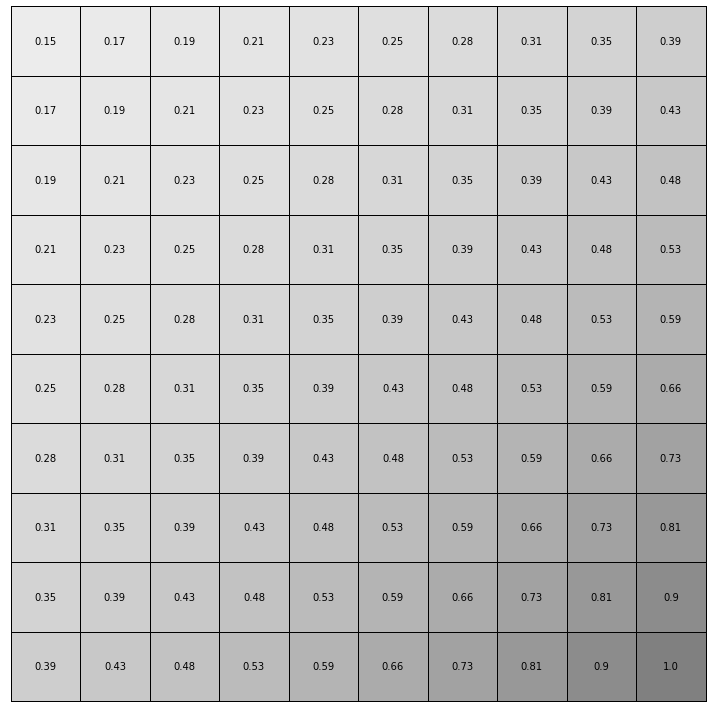

In [ ]:
v, v_list, iter, avg_time, total_time = value_iteration_v(mdp, render=True)

In [ ]:
show_videos("videos/", prefix="ValueiterationV")

Converting videos/ValueiterationV.avi


### Value iteration with the $Q$ function ###


The state-action value function $Q^{\pi}(s,a)$ defines the value of being in state $s$, taking action $a$ then following policy $\pi$. The Bellman Optimality Equation for $Q^*$ is
$$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y} P(s,a,y) \max_{a'}Q^*(y,a'). $$ 


**Question:** By taking inspiration from the `value_iteration_v(mdp)` function above, fill the blank (given with '\#Q[x,u]=...') in the code of `value_iteration_q(mdp)`.

In [ ]:

# ------------------------- Value Iteration with the Q function ----------------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


def value_iteration_q(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float], int, float, str]:
    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    stop = False

    if render:
        mdp.new_render("Value iteration Q")

    while not stop:
        # Start timer for the current iteration
        start_timer_iter = time.time()

        qold = q.copy()

        if render:
            mdp.render(q, title="Value iteration Q")

        for x in range(mdp.nb_states):
            for u in mdp.action_space.actions:
                if x in mdp.terminal_states:
                    # q[x, :] = ...
                    q[x, :] = mdp.r[x, :]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        # summ += ...
                        summ += mdp.P[x, u, y] * np.max(qold[y,:])
                    # q[x, u] = ...
                    q[x, u] = mdp.r[x, u] + mdp.gamma * summ

        iter += 1

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q)) # --> Frobenius norm of the matrix q

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)

    if render:
        mdp.render(q, title="Value iteration Q")

    total_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return q, q_list, iter, avg_time, total_time


Once you are done, run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


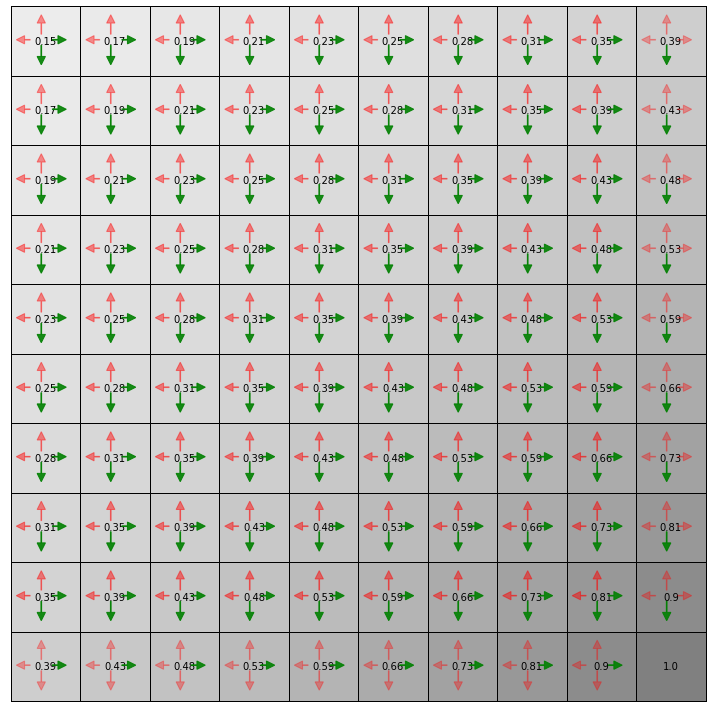

In [ ]:
q, q_list, iter, avg_time, total_time = value_iteration_q(mdp, render=True)

# print([item for item in q_list])
# print(q)

In [ ]:
show_videos("videos/", prefix="ValueiterationQ")

Converting videos/ValueiterationQ.avi


## Policy Iteration ##


The **policy iteration** algorithm is more complicated than **value iteration**.
Given a MDP and a policy $\pi$, **policy iteration** iterates the following steps: 

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be improved anymore.


### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state $s$ and following policy $\pi$. It is processed based on the Bellman Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$


where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.


Thus, given a policy $\pi$, one must first compute its value function $V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until convergence, that is using **value iteration**.
Then, one must determine if policy $\pi$ can be improved based on $V$. For that, in each state $s$, one can compute the Q-value $Q(s,a)$ of applying action $a$ and then following policy $\pi$ based on the just computed $V^\pi$, and replace the action $\pi(s)$ with $\arg\max_a Q(s,a)$.



In order to facilitate the coding of **policy iteration** algorithms, we first define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the `get_policy_from_v(v)` function which was given above. The main difference is that it takes a policy as argument and improves this policy when possible, thus is is more in the spirit of the `policy improvement` step of **policy iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given MDP, `v` is some value function in this MDP and `policy` is some policy and the function `evaluate_v(mdp, policy)` are also given. These functions are used to build the value function $V^\pi$ corresponding to policy $\pi$.


In [ ]:
def improve_policy_from_v(mdp: Mdp, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        v_temp = np.zeros(mdp.action_space.size)
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ
            else:  # if the state is final, then we only take the reward into account
                v_temp[u] = mdp.r[x, u]

        for u in mdp.action_space.actions:
            if v_temp[u] > v_temp[policy[x]]:
                policy[x] = u
    return policy

In [ ]:
def evaluate_one_step_v(mdp: Mdp, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
        else:  # if the state is final, then we only take the reward into account
            v_new[x] = mdp.r[x, policy[x]]
    return v_new


In [ ]:
def evaluate_v(mdp: Mdp, policy: np.ndarray) -> Tuple[np.ndarray, int, float]:
    # Outputs the state value function of a policy

    # Set timer and counter
    times = []
    iter = 0

    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    while not stop:
        # Start timer for the current iteration
        start_timer = time.time()

        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        iter += 1

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True

        end_timer = time.time()
        times.append(end_timer - start_timer)

    avg_time = np.mean(np.array(times))

    return v, iter, avg_time


To perform **policy iteration** we also need an initial random policy.

In [ ]:
from mazemdp import random_policy

**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [ ]:
# ------------------------- Policy Iteration with the V function ----------------------------#
# Given a MDP, this algorithm simultaneously computes the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float], int, int, float, float, str]:
    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    iter_elem = 0

    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)


    stop = False

    if render:
        mdp.new_render("Policy iteration V")

    while not stop:
        # Start timer for the current iteration 
        start_timer_iter = time.time()

        vold = v.copy()
        # Step 1 : Policy Evaluation
        # v = ...
        v, iter_elem_temp, avg_time_elem = evaluate_v(mdp, policy)
        
        iter_elem += iter_elem_temp
        iter += 1

        if render:
            mdp.render(v, title="Policy iteration V")
            mdp.plotter.render_pi(policy)

        # Step 2 : Policy Improvement
        # policy = ...
        policy = improve_policy_from_v(mdp, v, policy)

        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)

    if render:
        mdp.render(v, title="Policy iteration V")
        mdp.plotter.render_pi(policy)
    
    tot_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return v, v_list, iter, iter_elem, avg_time, avg_time_elem, tot_time


And finally run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


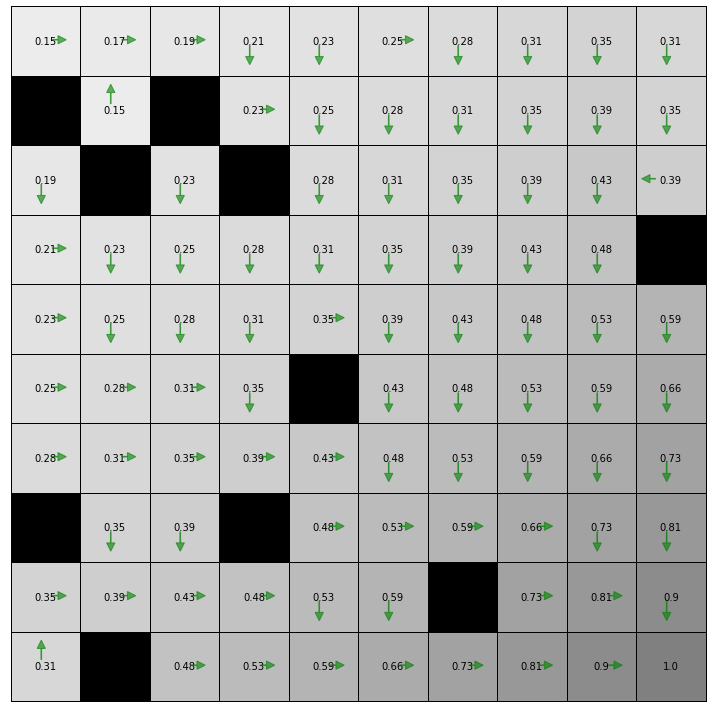

In [ ]:
v, v_list, iter, iter_elem, avg_time, avg_time_elem, tot_time = policy_iteration_v(mdp, render=True)

[1.0, 2.1416551193177673, 2.846951458416705, 3.458763999680427, 3.9425664119526136, 4.301829534621466, 4.580077678642328, 4.623280765312795, 4.623280765312795]
[0.1500946352969992, 0.16677181699666577, 0.1853020188851842, 0.2058911320946491, 0.22876792454961012, 0.25418658283290013, 0.28242953648100017, 0.31381059609000017, 0.34867844010000015, 0.38742048900000015, 0.16677181699666577, 0.1853020188851842, 0.2058911320946491, 0.22876792454961012, 0.25418658283290013, 0.28242953648100017, 0.31381059609000017, 0.34867844010000015, 0.38742048900000015, 0.43046721000000016, 0.1853020188851842, 0.2058911320946491, 0.22876792454961012, 0.25418658283290013, 0.28242953648100017, 0.31381059609000017, 0.34867844010000015, 0.38742048900000015, 0.43046721000000016, 0.47829690000000014, 0.2058911320946491, 0.22876792454961012, 0.25418658283290013, 0.28242953648100017, 0.31381059609000017, 0.34867844010000015, 0.38742048900000015, 0.43046721000000016, 0.47829690000000014, 0.5314410000000002, 0.228767

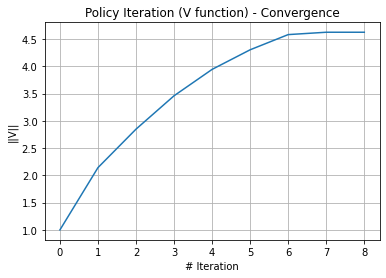

Converting videos/PolicyiterationV.avi


In [ ]:
print(v_list)
print([item for item in v])
print(len(v))

plt.plot(v_list)
plt.grid()
plt.title('Policy Iteration (V function) - Convergence')
plt.xlabel('# Iteration')
plt.ylabel('||V||')
plt.show()

show_videos("videos/", prefix="PolicyiterationV")

### Policy iteration with the $Q$ function ###


The **policy iteration** algorithm with the $Q$ function is the same as with the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy $\pi$ for $Q$ becomes: 
$$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
$$\pi^{(t+1)}(s) = \arg\max_aQ^{\pi^{(t)}}(s,a).$$


First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the state-action value function.

This function has the role of improving the policy.

In [ ]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs an already improved policy given the values of the Q function
    policy = np.argmax(q, axis=1)

    return policy


**Question:** By drawing inspiration on the functions give with the $v$ function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function below, where $q$ is some action value function, and the `evaluate_q(mdp, policy)` function.

In [ ]:
def evaluate_one_step_q(mdp: Mdp, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                # ...
                summ = 0
                for y in range(mdp.nb_states):
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                qnew[x, u] = mdp.r[x, u] + mdp.gamma*summ
            else:  # if the state is final, then we only take the reward into account
                # qnew[x, u] = ...
                qnew[x, u] = mdp.r[x, u]
    return qnew

In [ ]:
def evaluate_q(mdp: Mdp, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy

    # Set timer and counter
    times = []
    iter = 0

    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    while not stop:
        # Start timer for the current iteration
        start_timer = time.time()

        qold = q.copy()
        # q = ...
        q = evaluate_one_step_q(mdp, qold, policy)

        iter += 1

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True

        end_timer = time.time()
        times.append(end_timer - start_timer)

    avg_time = np.mean(np.array(times))

    return q, iter, avg_time

**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [ ]:
# ------------------------- Policy Iteration with the Q function ----------------------------#
# Given a MDP, this algorithm simultaneously computes the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: Mdp, render: bool = True) -> Tuple[np.ndarray, List[float], int, int, float, float, str]:
    """policy iteration over the q function."""

    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    iter_elem = 0
    
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.new_render("Policy iteration Q")

    while not stop:
        # Start timer for the current iteration 
        start_timer_iter = time.time()

        qold = q.copy()

        if render:
            mdp.render(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        # q = ...
        q, iter_elem_temp, avg_time_elem = evaluate_q(mdp, policy)

        iter_elem += iter_elem_temp
        iter += 1

        # Step 2 : Policy improvement
        # policy = ...
        policy = get_policy_from_q(q)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)

    if render:
        mdp.render(q, get_policy_from_q(q), title="Policy iteration Q")

    tot_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return q, q_list, iter, iter_elem, avg_time, avg_time_elem, tot_time


Finally, run it.

In [ ]:
q, q_list, iter, iter_elem, avg_time, avg_time_elem, tot_time = policy_iteration_q(mdp, render=False)

In [ ]:
show_videos("videos/", prefix="PolicyiterationQ")

Converting videos/PolicyiterationQ.avi


## Experimental comparisons ##

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dynamic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dynamic programming functions in terms of iterations, elementary operations and time taken.

In [ ]:
# -------- Plot convergence of Value and Policy Iteration algorithms ----------#
def plot_convergence_vi_pi(m, render): 
    v, v_list1 = value_iteration_v(m, render)[0:2]
    q, q_list1 = value_iteration_q(m, render)[0:2]
    v, v_list2 = policy_iteration_v(m, render)[0:2]
    q, q_list2 = policy_iteration_q(m, render)[0:2]

    plt.subplots()
    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    x_tks = range(max(len(v_list1), len(q_list1), len(v_list2), len(q_list2)))

    plt.xlabel('Number of episodes')
    plt.xticks(x_tks)
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='lower right')
    plt.title("Comparison of convergence rates")
    plt.show()


You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.

---------------------------
MAZE SIZE:3
---------------------------


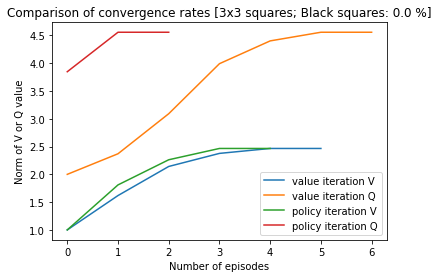

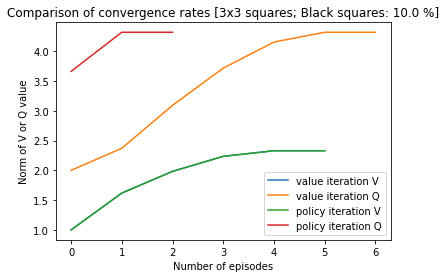

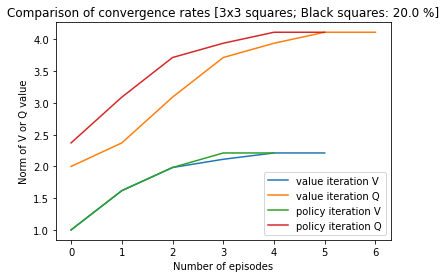

╒══════════════════════╤════════════════╤════════════════════════════╤════════════════╤═══════════════════════════╤══════════════╕
│ Algorithm            │   # Iterations │ # elementary evaluations   │   average time │ average time elementary   │ total time   │
╞══════════════════════╪════════════════╪════════════════════════════╪════════════════╪═══════════════════════════╪══════════════╡
│ Black Squares:0.0 %  │                │                            │                │                           │              │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration V    │              6 │ undefined                  │    0.000356913 │ undefined                 │ 0s 2ms       │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration Q    │              7 │ undefined                  │    0.0017499

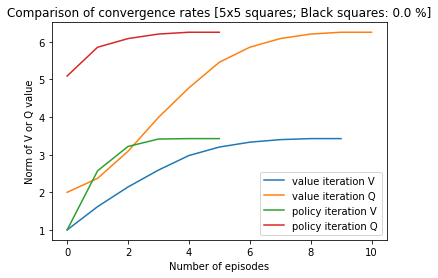

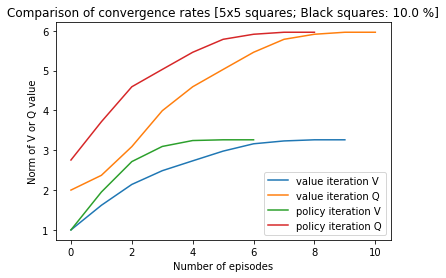

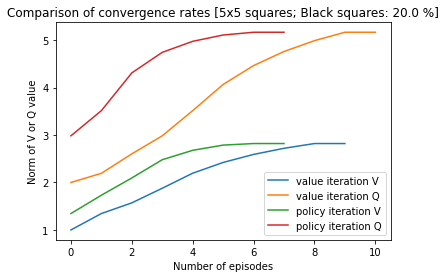

╒══════════════════════╤════════════════╤════════════════════════════╤════════════════╤═══════════════════════════╤══════════════╕
│ Algorithm            │   # Iterations │ # elementary evaluations   │   average time │ average time elementary   │ total time   │
╞══════════════════════╪════════════════╪════════════════════════════╪════════════════╪═══════════════════════════╪══════════════╡
│ Black Squares:0.0 %  │                │                            │                │                           │              │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration V    │             10 │ undefined                  │     0.0033432  │ undefined                 │ 0s 33ms      │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration Q    │             11 │ undefined                  │     0.022428

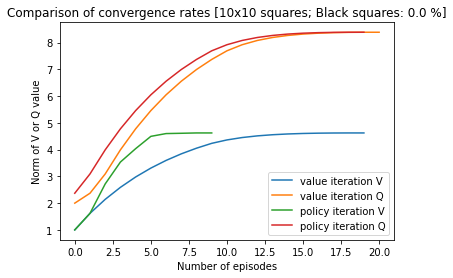

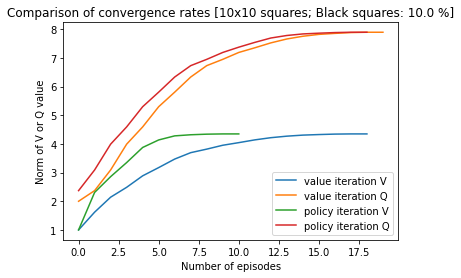

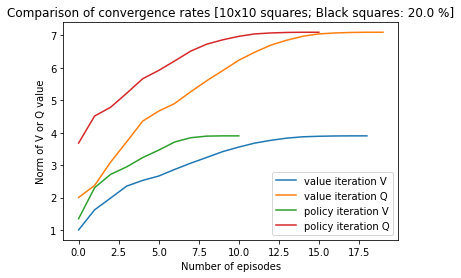

╒══════════════════════╤════════════════╤════════════════════════════╤════════════════╤═══════════════════════════╤══════════════╕
│ Algorithm            │   # Iterations │ # elementary evaluations   │   average time │ average time elementary   │ total time   │
╞══════════════════════╪════════════════╪════════════════════════════╪════════════════╪═══════════════════════════╪══════════════╡
│ Black Squares:0.0 %  │                │                            │                │                           │              │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration V    │             20 │ undefined                  │      0.0290187 │ undefined                 │ 0s 580ms     │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼──────────────┤
│ Value Iteration Q    │             21 │ undefined                  │      0.24324

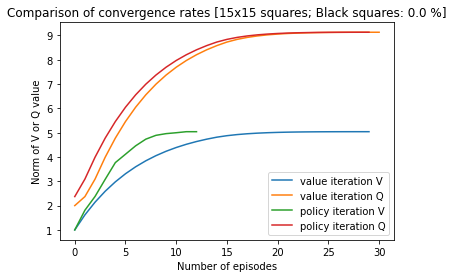

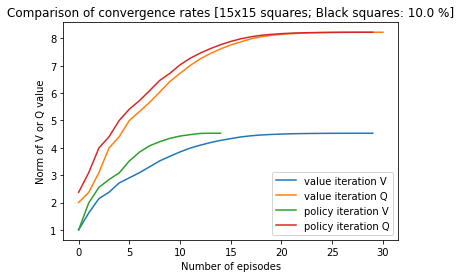

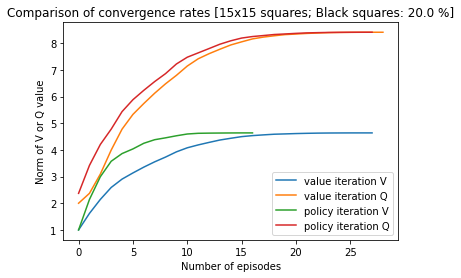

╒══════════════════════╤════════════════╤════════════════════════════╤════════════════╤═══════════════════════════╤═══════════════╕
│ Algorithm            │   # Iterations │ # elementary evaluations   │   average time │ average time elementary   │ total time    │
╞══════════════════════╪════════════════╪════════════════════════════╪════════════════╪═══════════════════════════╪═══════════════╡
│ Black Squares:0.0 %  │                │                            │                │                           │               │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼───────────────┤
│ Value Iteration V    │             30 │ undefined                  │      0.139242  │ undefined                 │ 4s 177ms      │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼───────────────┤
│ Value Iteration Q    │             31 │ undefined                  │      

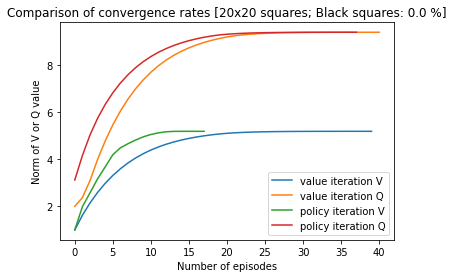

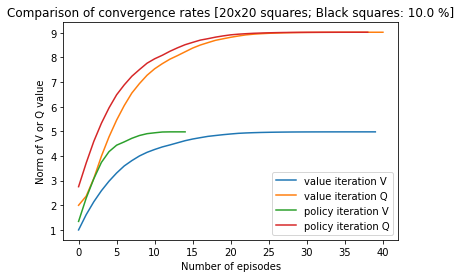

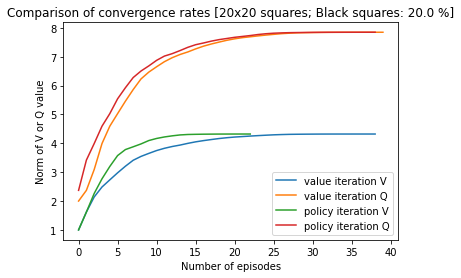

╒══════════════════════╤════════════════╤════════════════════════════╤════════════════╤═══════════════════════════╤═══════════════╕
│ Algorithm            │   # Iterations │ # elementary evaluations   │   average time │ average time elementary   │ total time    │
╞══════════════════════╪════════════════╪════════════════════════════╪════════════════╪═══════════════════════════╪═══════════════╡
│ Black Squares:0.0 %  │                │                            │                │                           │               │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼───────────────┤
│ Value Iteration V    │             40 │ undefined                  │       0.419382 │ undefined                 │ 16s 775ms     │
├──────────────────────┼────────────────┼────────────────────────────┼────────────────┼───────────────────────────┼───────────────┤
│ Value Iteration Q    │             41 │ undefined                  │      

In [ ]:
def plot_convergence(v_listV, v_listQ, q_listV, q_listQ, title):
    plt.subplots()
    plt.plot(range(len(v_listV)), v_listV, label='value iteration V')
    plt.plot(range(len(v_listQ)), v_listQ, label='value iteration Q')
    plt.plot(range(len(q_listV)), q_listV, label='policy iteration V')
    plt.plot(range(len(q_listQ)), q_listQ, label='policy iteration Q')

    # x_tks = range(max(len(v_listV), len(v_listQ), len(q_listV), len(q_listQ)))

    plt.xlabel('Number of episodes')
    # plt.xticks(x_tks)
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='lower right')
    if title == None:
        plt.title("Comparison of convergence rates")
    else: 
        plt.title("Comparison of convergence rates"+title)
    plt.show()

# def draw_single_table()
# def draw_convergence_table(maze_size, black_squares_percent):




maze_sizes = [3, 5, 10, 15, 20]
black_squares_percents = [0.0, 0.1, 0.2]#, 0.3, 0.5]
render = False # we don't want to display the drawing of the maze with the optimal policy found

for maze_size in maze_sizes:
    print('---------------------------')
    print('MAZE SIZE:' + str(maze_size))
    print('---------------------------')
    table = [['Algorithm','# Iterations', '# elementary evaluations', \
              'average time', 'average time elementary', 'total time']]
    for black_squares_percent in black_squares_percents:
        mdp = create_random_maze(maze_size, maze_size, black_squares_percent)

        v_valueV, v_list_valueV, iter_valueV, avg_time_valueV, tot_time_valueV = \
         value_iteration_v(mdp, render)
        q_valueQ, q_list_valueQ, iter_valueQ, avg_time_valueQ, tot_time_valueQ = \
         value_iteration_q(mdp, render)
        v_policyV, v_list_policyV, iter_policyV, iter_elem_policyV, avg_time_policyV, \
            avg_time_elem_policyV, tot_time_policyV = policy_iteration_v(mdp, render)
        q_policyQ, q_list_policyQ, iter_policyQ, iter_elem_policyQ, avg_time_policyQ, \
            avg_time_elem_policyQ, tot_time_policyQ = policy_iteration_q(mdp, render)

        table.append(['Black Squares:' + str(black_squares_percent*100) + ' %'])
        table.append(['Value Iteration V', iter_valueV, 'undefined', \
                      avg_time_valueV, 'undefined', tot_time_valueV])
        table.append(['Value Iteration Q', iter_valueQ, 'undefined',  \
                      avg_time_valueQ, 'undefined', tot_time_valueQ])
        table.append(['Policy Iteration V', iter_policyV, iter_elem_policyV, \
                      avg_time_policyV, avg_time_elem_policyV, tot_time_policyV])
        table.append(['Policy Iteration Q', iter_policyQ, iter_elem_policyQ, \
                      avg_time_policyQ, avg_time_elem_policyQ, tot_time_policyQ])

        #if black_squares_percent == 0.0:
        plot_convergence(v_list_valueV, q_list_valueQ, v_list_policyV, q_list_policyQ, \
        ' ['+ str(maze_size) + 'x' + str(maze_size) + ' squares; Black squares: ' \
        + str(black_squares_percent*100) + ' %]')

    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


**Question:** Run the code below and visualize the results of the different algorithms

In [ ]:
# plot_convergence_vi_pi(mdp, False)


Given the results above, discuss the relative computational efficiency of these methods. Write your discussion below.

**Discussion**







First of all, the analysis was performed:
- for different maze sizes [3, 5, 10, 15, 20]
    - for different percentages of black squares [0.0, 0.1, 0.2]


For what concerns the number of iterations, the following considerations can be made:

- As an overall observation, it is possible to state that the policy iteration V algorithm tends to assume a low value. In particular, the bigger the dimension of the maze the lower the number of iterations of the policy iteration V algorithm with respect to the other algorithms.
- On the other hand, the policy iteration algorithm presents less satisfactory results: it has a low number of iterations only with 3x3-dimension mazes and black squares percentage lower than 20% while in all the other cases the number of iterations becomes comparable to that of the value iteration algorithms.
- Finally, the value iteration algorithms has the highest number of iterations in all the cases, especially the value iteration Q algorithm.


For what concerns the number of elementary V or Q updates, only a comparison between the policy iteration algorithms is possible. Indeed, value iteration algorithms make no difference between one algorithm step and one evaluation of V or Q. 
The following observations have been stated:

- From the obtained results, it is has been noticed that the policy iteration V algorithm has a lower number of elementary operations with the only exception of the case of 3x3-dimension maze and black squares percentage less than 20%. In particular, the bigger the dimension of the maze the bigger the difference of number of elementary operations between the two algorithms


The resulting data give the opportunity to a discussion about the average time required by the different algorithms. As expected, incrementing the size of the maze and the percerntage of black squares, the time required to find the optimal policy increases. The followings can be highlighted:

- The average time is higher for value iteration Q and policy iteration Q algorithms.
- The value iteration V algorithm always requires an average time one order of magnitude lower with respect to the value iteration Q algorithm. 
- The policy iteration V algorithm requires an increasing time to find the optimal policy. This time becomes nearer and nearer to that of the algorithms that imply Q function (that is value iteration Q and policy iteration Q algorithms) for bigger mazes. That is to say, the smaller the maze the more efficient the policy iteration V algorithm.


As regards the average time require for each elementary operation, similarly to the number of elementary updates, a comparison is possible only between policy iteration algorithms. The following considerations can be made:

- Usually, the policy iteration V algorithm takes an average elementary operation time one order of magnitude lower with respect to policy iteration Q algorithm.
- Moreover, when the dimension of the maze increases, the average time for each operation, for both the algorithms, increases. Starting from an order of magnitude of $10^{-5}$ / $10^{-4}$ for 3x3-dimension mazes, it settles to an order of $10^{-2}$ / $10^{-1}$ for 20x20-dimension mazes.

Finally, a discussion about total time required by the algorithms to find the optimal policy leads to the following statements:
- With a 3x3-dimension maze (and black squares percentages between 10% and 20%) the highest total time is required by the value iteration Q algorithm.
- When a 5x5-dimension maze (and any black squares percentage) is used, the time took by the value iteration Q algorithm becomes comparable to that of the policy iteration Q algorithm.
- By increasing the dimension of the maze until 10x10 it is possible to notice that a policy iteration Q algorithm takes a time higher and higher until it becomes almost the double of that required by the value iteration Q algorithm.
- This difference increases with higher mazes until the time require by the policy iteration Q is between 3 and 5 times bigger for 20x20-dimension mazes. 



**Up to you:**

## Additional studies ##

To go further, you may code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step

In [ ]:
from mazemdp.toolbox import egreedy

def get_greedy_policy_from_q(q: np.ndarray, epsilon: float):
    policy = np.zeros(mdp.nb_states, dtype=int)
    for x in range(mdp.nb_states):
        policy[x] = int(egreedy(q, x, epsilon))
    return policy

In [ ]:
def generalized_policy_iteration_q(mdp: Mdp, epsilon: float, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""

    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    iter_elem = 0
    
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.new_render("Policy iteration Q")

    while not stop:
        # Start timer for the current iteration 
        start_timer_iter = time.time()

        qold = q.copy()

        if render:
            mdp.render(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        # q = ...
        q, iter_elem_temp, avg_time_elem = evaluate_q(mdp, policy)

        iter_elem += iter_elem_temp
        iter += 1

        # Step 2 : Policy improvement
        # policy = ...
        policy = get_greedy_policy_from_q(q, epsilon)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)
    if render:
        mdp.render(q, policy, title="Policy iteration Q")

    tot_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return q, q_list, iter, iter_elem, avg_time, avg_time_elem, tot_time


/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


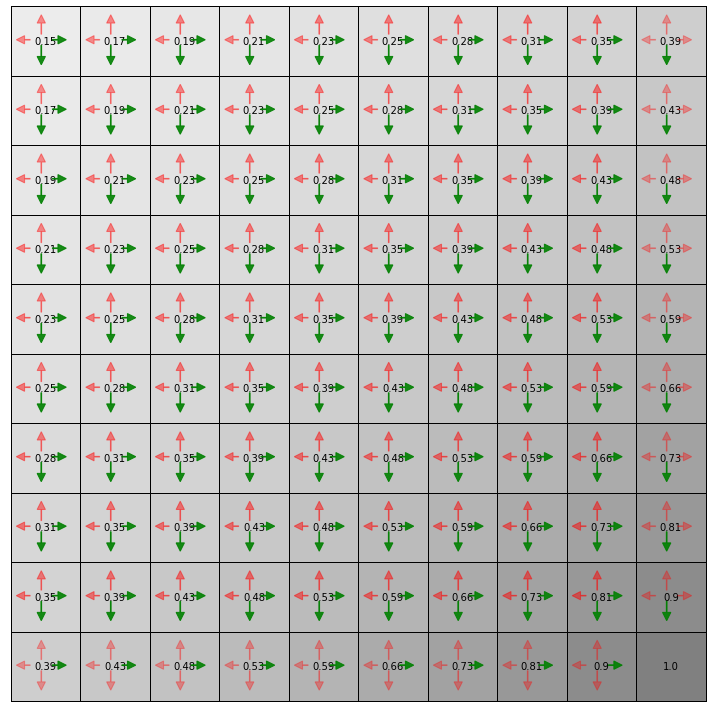

In [ ]:
q, q_list, iter, iter_elem, avg_time, avg_time_elem, tot_time = generalized_policy_iteration_q(mdp, 0.001, render=True)

In [ ]:
# Mdp 10x10 with 0.0 % black squares

print('Number of iterations: ' + str(iter))
print('Number of elementary evaluations: ' + str(iter_elem))
print('Average time per iteration: ' + str(avg_time))
print('Average time per elementary evaluation: ' + str(avg_time_elem))
print('Total time: ' + str(tot_time))

Number of iterations: 11
Number of elementary evaluations: 154
Average time per iteration: 1.2580457817424426
Average time per elementary evaluation: 0.03507916132609049
Total time: 14s 597ms


**Discussion**



As a benchmark, let us consider the case of a 10x10 maze with no black squares.

Comparing the results with the ones obtained with a non-generalized policy iteration (Q), it can be seen that the result has not improved: while the number of iterations and elementary evaluations has not changed significantly (it is lower, but of the same order of magnitude), the total time required for the algorithm has increased by a certain extent. It It is not the time taken by the elementary evaluation the key factor of this loss in performance, but rather the time taken by the single iteration, which is much larger than the one taken by non-generalized policy iteration (Q).
This could be explained by a poor tuning of the parameter $\epsilon$, which could slow down the convergence by allowing for a randomic choice of the following action to take.